# PFDA project

***

Weather data from [MET Eireann Historical Data](https://www.met.ie/climate/available-data/historical-data).

In [83]:
# Import required libraries
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox
import seaborn as sns       # statistical plotting library

import pandas as pd         # data analysis
import geopandas as gpd     # geospatial data analysis
from shapely.geometry import Point  # plotting points on map

from sklearn.linear_model import LinearRegression

import numpy as np          # array handling
import skunk                # for handling svg
import cairosvg             # for handling svg, png, pdf
from IPython.display import Image   # display png
import requests


Define URLs to fetch data for a each weather station:

In [84]:
# Data sources (hourly)
donegal_data_url = "https://cli.fusio.net/cli/climate_data/webdata/hly1575.csv" # Malin Head 2009-
cork_data_url = "https://cli.fusio.net/cli/climate_data/webdata/hly775.csv"     # Sherkin Island 2004-
dublin_data_url = "https://cli.fusio.net/cli/climate_data/webdata/hly3723.csv"  # Casement 1944-
galway_data_url = "https://cli.fusio.net/cli/climate_data/webdata/hly275.csv"   # Macehead 2003-
carlow_data_url = "https://cli.fusio.net/cli/climate_data/webdata/hly375.csv"   # Oak Park 2003-

First fetch one of the CSVs using a URL above, and check what the metadata in the head of the CSV looks like:

In [85]:
# Fetch the CSV file from the URL
response = requests.get(donegal_data_url)

# Check if the request was successful
if response.status_code == 200:
    # Split the content into lines
    lines = response.text.splitlines()

    # Print the first 22 lines
    for line in lines[:22]:
        print(line)
else:
    print(f"Failed to fetch the file. Status code: {response.status_code}")

Station Name: MALIN HEAD
Station Height: 20 M 
Latitude:55.372  ,Longitude: -7.339


date:  -  Date and Time (utc)
rain:  -  Precipitation Amount (mm)	  
temp:  -  Air Temperature (C)	
wetb:  -  Wet Bulb Temperature (C)
dewpt: -  Dew Point Temperature (C)             
rhum:  -  Relative Humidity (%)
vappr: -  Vapour Pressure (hPa)	 
msl:   -  Mean Sea Level Pressure (hPa)
wdsp:  -  Mean Wind Speed (knot)
wddir: -  Predominant Wind Direction (degree)
ww:    -  Synop code for Present Weather
w:     -  Synop code for Past Weather
sun:   -  Sunshine duration (hours)
vis:   -  Visibility (m)
clht:  -  Cloud height (100's of ft) - 999 if none 
clamt: -  Cloud amount
ind:   -  Indicator


Now to load each CSV into its own dataframe. 

We can specify the number of rows to skip for each csv to skip the metadata header. They don't all have the same number of rows of metadata, so we need to check each one individually.

In [101]:
# Load the data from the URLs into DataFrames
donegal_df = pd.read_csv(donegal_data_url, skiprows=22, low_memory=False)
cork_df = pd.read_csv(cork_data_url, skiprows=16, low_memory=False)
dublin_df = pd.read_csv(dublin_data_url, skiprows=22, low_memory=False)
galway_df = pd.read_csv(galway_data_url, skiprows=16, low_memory=False)
carlow_df = pd.read_csv(carlow_data_url, skiprows=16, low_memory=False)

Check each dataframe is loaded correctly:

In [102]:
# print df head
donegal_df.head(5)
#cork_df.head(5)
#dublin_df.head(5)
#galway_df.head(5)
#carlow_df.head(5)

,date,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,...,ind.3,wdsp,ind.4,wddir,ww,w,sun,vis,clht,clamt
0,01-may-1955 01:00,0,0.0,0,8.5,0,7.2,5.5,9.1,83,...,0,11,0,130,3,2,0.0,30000,40,7
1,01-may-1955 02:00,0,0.0,0,8.2,0,7.2,6.1,9.3,85,...,0,11,0,120,1,2,0.0,30000,100,6
2,01-may-1955 03:00,3,0.0,0,7.3,0,6.6,5.5,9.3,91,...,0,8,0,120,1,2,0.0,30000,220,5
3,01-may-1955 04:00,3,0.0,0,7.8,0,7.2,6.1,9.6,91,...,0,18,0,130,3,2,0.0,30000,90,7
4,01-may-1955 05:00,0,0.0,0,8.1,0,7.3,6.6,9.7,89,...,0,9,0,110,2,2,0.0,40000,90,7


In [103]:
# Check datatypes 
donegal_df.dtypes

date      object
ind        int64
rain      object
ind.1      int64
temp     float64
ind.2      int64
wetb      object
dewpt     object
vappr     object
rhum      object
msl      float64
ind.3      int64
wdsp      object
ind.4      int64
wddir     object
ww        object
w         object
sun       object
vis       object
clht      object
clamt     object
dtype: object

We need to convert the entire dataframe to numeric before working with the data.

- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_numeric.html

Also need to convert the date column to DateTime format.

We can create a list of the location dataframes, and loop through each dataframe then:
- convert to numeric (except the date column)
- convert 'date' to DateTime

In [105]:
# List of DataFrames
dataframes = [donegal_df, cork_df, dublin_df, galway_df, carlow_df]

# Loop through the list of DataFrames and apply modifications
for i in range(len(dataframes)):
    df = dataframes[i]
    
    # Convert all columns to numeric except 'date'
    for col in df.columns:
        if col != 'date':  # skip the 'date' column
            df[col] = pd.to_numeric(df[col], errors='coerce')  # Coerce non-numeric values to NaN
    
    # Convert 'date' column to DateTime format
    df['date'] = pd.to_datetime(df['date'], errors='coerce', format='%d-%b-%Y %H:%M')
    
    # Update the list with the modified DataFrame
    dataframes[i] = df

In [106]:
for df in dataframes:
    print(df.dtypes)

date     datetime64[ns]
ind               int64
rain            float64
ind.1             int64
temp            float64
ind.2             int64
wetb            float64
dewpt           float64
vappr           float64
rhum            float64
msl             float64
ind.3             int64
wdsp            float64
ind.4             int64
wddir           float64
ww              float64
w               float64
sun             float64
vis             float64
clht            float64
clamt           float64
dtype: object
date     datetime64[ns]
ind               int64
rain            float64
ind.1             int64
temp            float64
ind.2             int64
wetb            float64
dewpt           float64
vappr           float64
rhum            float64
msl             float64
ind.3             int64
wdsp            float64
ind.4             int64
wddir           float64
dtype: object
date     datetime64[ns]
ind               int64
rain            float64
ind.1             int64
temp        

In [107]:
print(donegal_df.dtypes)

date     datetime64[ns]
ind               int64
rain            float64
ind.1             int64
temp            float64
ind.2             int64
wetb            float64
dewpt           float64
vappr           float64
rhum            float64
msl             float64
ind.3             int64
wdsp            float64
ind.4             int64
wddir           float64
ww              float64
w               float64
sun             float64
vis             float64
clht            float64
clamt           float64
dtype: object


In [108]:
# Have a look at date column again
donegal_df['date'].head(5)

0   1955-05-01 01:00:00
1   1955-05-01 02:00:00
2   1955-05-01 03:00:00
3   1955-05-01 04:00:00
4   1955-05-01 05:00:00
Name: date, dtype: datetime64[ns]

Check a couple dataframes and see the datatypes:

In [109]:
# Check datatypes
donegal_df.dtypes
#carlow_df.dtypes

date     datetime64[ns]
ind               int64
rain            float64
ind.1             int64
temp            float64
ind.2             int64
wetb            float64
dewpt           float64
vappr           float64
rhum            float64
msl             float64
ind.3             int64
wdsp            float64
ind.4             int64
wddir           float64
ww              float64
w               float64
sun             float64
vis             float64
clht            float64
clamt           float64
dtype: object

In [110]:
# Statistical summary of the dataframe (numeric only)
donegal_df.describe(include='number')

,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,msl,ind.3,wdsp,ind.4,wddir,ww,w,sun,vis,clht,clamt
count,610008.000000,610005.000000,610008.000000,610008.000000,610008.000000,610002.000000,610002.000000,610002.000000,610002.000000,610008.000000,610008.000000,609956.000000,610008.000000,609902.000000,479140.000000,479140.000000,479256.000000,479060.000000,479116.000000,479116.000000
mean,0.441971,0.124691,0.002913,9.762455,0.012683,8.387794,6.776162,10.238539,82.045490,1011.900327,1.371936,15.217576,1.361621,199.712183,20.448197,21.179874,0.145539,32672.775435,263.685454,5.939409
std,0.908930,0.451936,0.056653,3.905388,0.209615,3.808678,4.334736,2.948037,10.008081,13.039619,0.934213,7.822520,0.904935,88.962834,25.932830,27.867239,0.308071,19416.968823,396.292407,2.276091
min,-1.000000,0.000000,0.000000,-6.000000,0.000000,-6.800000,-17.700000,2.400000,20.000000,943.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,6.900000,0.000000,5.600000,3.700000,7.900000,76.000000,1003.900000,0.000000,9.000000,0.000000,140.000000,2.000000,2.000000,0.000000,16000.000000,20.000000,5.000000
50%,0.000000,0.000000,0.000000,9.800000,0.000000,8.500000,7.000000,10.000000,83.000000,1013.100000,2.000000,14.000000,2.000000,200.000000,3.000000,11.000000,0.000000,30000.000000,45.000000,7.000000
75%,0.000000,0.000000,0.000000,12.700000,0.000000,11.300000,10.000000,12.300000,90.000000,1021.100000,2.000000,20.000000,2.000000,270.000000,25.000000,22.000000,0.000000,45000.000000,250.000000,8.000000
max,7.000000,16.600000,2.000000,26.600000,6.000000,21.500000,19.400000,22.400000,100.000000,1051.200000,7.000000,63.000000,7.000000,360.000000,99.000000,98.000000,1.000000,75000.000000,999.000000,8.000000


There are a lot of columns in each dataframe. We can drop any we are not interested in, keeping only the columns of interest such as:

- date (date)
- windspeed (wdsp)
- temperature (temp)
- rain (rain) 

We need to rename wdsp, temp, and rain columns to include location name, for combining them later into one dataframe. We need to differentiate each column for its location.

In [111]:
def process_dataframe(df, location):
    # Select relevant columns and rename them with the location name
    df = df[['date', 'temp', 'rain', 'wdsp']].copy()
    df.rename(columns={
        'temp': f'temp_{location}',
        'rain': f'rain_{location}',
        'wdsp': f'wdsp_{location}'
    }, inplace=True)
    return df

# List of DataFrames and their corresponding location names
dataframes = {
    'donegal': donegal_df,
    'cork': cork_df,
    'dublin': dublin_df,
    'galway': galway_df,
    'carlow': carlow_df
}

# Loop through the DataFrames and apply the processing function
for location, df in dataframes.items():
    dataframes[location] = process_dataframe(df, location)

# Access processed DataFrames like this
donegal_df = dataframes['donegal']
cork_df = dataframes['cork']
dublin_df = dataframes['dublin']
galway_df = dataframes['galway']
carlow_df = dataframes['carlow']


In [ ]:
# Check a dataframe if copy/rename was successful
donegal_df.head(5)

,date,temp_donegal,rain_donegal,wdsp_donegal
0,1955-05-01 01:00:00,8.5,0.0,11.0
1,1955-05-01 02:00:00,8.2,0.0,11.0
2,1955-05-01 03:00:00,7.3,0.0,8.0
3,1955-05-01 04:00:00,7.8,0.0,18.0
4,1955-05-01 05:00:00,8.1,0.0,9.0


In [ ]:
# Describe one of the new dataframes
donegal_df.describe(include='number')
#carlow_df.describe(include='number')

,temp_donegal,rain_donegal,wdsp_donegal
count,610008.000000,610005.000000,609956.000000
mean,9.762455,0.124691,15.217576
std,3.905388,0.451936,7.822520
min,-6.000000,0.000000,0.000000
25%,6.900000,0.000000,9.000000
50%,9.800000,0.000000,14.000000
75%,12.700000,0.000000,20.000000
max,26.600000,16.600000,63.000000


Merging dataframes:

- https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html#merge

This only works for two dataframes, For multiple dataframes, we have to call it several times.

In [16]:
# merge the datasets on the date columns
combined_df = donegal_df.merge(
    cork_df, on=['date'], how='inner'
).merge(
    dublin_df, on=['date'], how='inner'
).merge(
    galway_df, on=['date'], how='inner'
).merge(
    carlow_df, on=['date'], how='inner'
)

In [17]:
# have a lok at the new combined dataframe
combined_df

,date,temp_donegal,rain_donegal,wdsp_donegal,temp_cork,rain_cork,wdsp_cork,temp_dublin,rain_dublin,wdsp_dublin,temp_galway,rain_galway,wdsp_galway,temp_carlow,rain_carlow,wdsp_carlow
0,2004-04-30 01:00:00,8.9,0.0,29.0,NaN,NaN,NaN,5.9,0.0,4.0,7.9,0.0,17.0,6.2,0.0,7.0
1,2004-04-30 02:00:00,8.9,0.0,27.0,NaN,NaN,NaN,7.0,0.0,6.0,7.4,0.0,19.0,6.3,0.0,7.0
2,2004-04-30 03:00:00,8.9,0.0,28.0,NaN,NaN,NaN,7.1,0.0,6.0,7.9,0.0,14.0,6.2,0.0,7.0
3,2004-04-30 04:00:00,8.9,0.0,28.0,NaN,NaN,NaN,7.2,0.0,6.0,8.0,0.0,19.0,6.4,0.0,8.0
4,2004-04-30 05:00:00,8.9,0.0,29.0,NaN,NaN,NaN,7.4,0.0,6.0,8.2,0.0,21.0,6.6,0.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180475,2024-11-30 20:00:00,14.6,0.0,23.0,12.8,0.0,17.0,14.0,0.1,19.0,12.5,0.0,24.0,13.4,0.5,16.0
180476,2024-11-30 21:00:00,13.8,0.1,23.0,12.6,0.0,11.0,13.4,0.6,16.0,12.6,0.0,19.0,13.3,1.5,16.0
180477,2024-11-30 22:00:00,13.4,0.0,20.0,12.7,0.0,12.0,13.6,0.2,15.0,11.5,1.3,21.0,13.4,0.2,13.0
180478,2024-11-30 23:00:00,12.6,0.0,20.0,12.7,0.0,14.0,13.4,0.0,15.0,12.2,0.2,18.0,13.1,0.3,14.0


Clean data a bit, theres going to be some missing rows etc.

In [18]:
# replace empty strings with NaN
#df = df.replace(["", " ", "NA", "null"], np.nan)

In [82]:
# check how many missing entries in each column
combined_df.isna().sum()


NameError: name 'combined_df' is not defined

In [20]:
# drop empties
combined_df.dropna(inplace=True)

In [21]:
# check missing entries again
combined_df.isna().sum()

date            0
temp_donegal    0
rain_donegal    0
wdsp_donegal    0
temp_cork       0
rain_cork       0
wdsp_cork       0
temp_dublin     0
rain_dublin     0
wdsp_dublin     0
temp_galway     0
rain_galway     0
wdsp_galway     0
temp_carlow     0
rain_carlow     0
wdsp_carlow     0
dtype: int64

In [22]:
# view the first row in the dataframe
combined_df.iloc[0]

date            2004-05-01 01:00:00
temp_donegal                    8.9
rain_donegal                    0.0
wdsp_donegal                    8.0
temp_cork                      10.8
rain_cork                       0.0
wdsp_cork                      14.0
temp_dublin                     9.0
rain_dublin                     0.0
wdsp_dublin                     7.0
temp_galway                     9.1
rain_galway                     0.0
wdsp_galway                     8.0
temp_carlow                     8.2
rain_carlow                     0.0
wdsp_carlow                    10.0
Name: 24, dtype: object

In [23]:
# view datatypes
combined_df.dtypes

date            datetime64[ns]
temp_donegal           float64
rain_donegal           float64
wdsp_donegal           float64
temp_cork              float64
rain_cork              float64
wdsp_cork              float64
temp_dublin            float64
rain_dublin            float64
wdsp_dublin            float64
temp_galway            float64
rain_galway            float64
wdsp_galway            float64
temp_carlow            float64
rain_carlow            float64
wdsp_carlow            float64
dtype: object

In [24]:
# check df datatypoes again
combined_df.dtypes

date            datetime64[ns]
temp_donegal           float64
rain_donegal           float64
wdsp_donegal           float64
temp_cork              float64
rain_cork              float64
wdsp_cork              float64
temp_dublin            float64
rain_dublin            float64
wdsp_dublin            float64
temp_galway            float64
rain_galway            float64
wdsp_galway            float64
temp_carlow            float64
rain_carlow            float64
wdsp_carlow            float64
dtype: object

In [25]:
# display new combined windspeed df
combined_df

,date,temp_donegal,rain_donegal,wdsp_donegal,temp_cork,rain_cork,wdsp_cork,temp_dublin,rain_dublin,wdsp_dublin,temp_galway,rain_galway,wdsp_galway,temp_carlow,rain_carlow,wdsp_carlow
24,2004-05-01 01:00:00,8.9,0.0,8.0,10.8,0.0,14.0,9.0,0.0,7.0,9.1,0.0,8.0,8.2,0.0,10.0
25,2004-05-01 02:00:00,8.8,0.0,7.0,11.1,0.0,12.0,8.9,0.0,6.0,8.9,0.0,9.0,9.0,0.0,11.0
26,2004-05-01 03:00:00,7.2,0.0,4.0,10.6,0.0,12.0,8.3,0.0,6.0,8.6,0.0,10.0,7.8,0.0,10.0
27,2004-05-01 04:00:00,8.1,0.0,2.0,10.3,0.0,8.0,8.0,0.0,8.0,8.5,0.0,8.0,7.2,0.0,7.0
28,2004-05-01 05:00:00,7.0,0.0,2.0,10.3,0.0,14.0,7.8,0.0,6.0,8.4,0.0,12.0,6.5,0.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180475,2024-11-30 20:00:00,14.6,0.0,23.0,12.8,0.0,17.0,14.0,0.1,19.0,12.5,0.0,24.0,13.4,0.5,16.0
180476,2024-11-30 21:00:00,13.8,0.1,23.0,12.6,0.0,11.0,13.4,0.6,16.0,12.6,0.0,19.0,13.3,1.5,16.0
180477,2024-11-30 22:00:00,13.4,0.0,20.0,12.7,0.0,12.0,13.6,0.2,15.0,11.5,1.3,21.0,13.4,0.2,13.0
180478,2024-11-30 23:00:00,12.6,0.0,20.0,12.7,0.0,14.0,13.4,0.0,15.0,12.2,0.2,18.0,13.1,0.3,14.0


In [26]:
# Describe only numeric columns
combined_df.select_dtypes(include=['number']).describe()

,temp_donegal,rain_donegal,wdsp_donegal,temp_cork,rain_cork,wdsp_cork,temp_dublin,rain_dublin,wdsp_dublin,temp_galway,rain_galway,wdsp_galway,temp_carlow,rain_carlow,wdsp_carlow
count,179068.000000,179068.000000,179068.000000,179068.000000,179068.000000,179068.000000,179068.000000,179068.000000,179068.000000,179068.000000,179068.000000,179068.000000,179068.000000,179068.000000,179068.000000
mean,10.186909,0.132571,14.664345,11.248342,0.125753,12.356881,10.070081,0.089754,9.687197,10.867038,0.122755,14.470129,10.205323,0.097838,7.409872
std,3.890670,0.463010,7.308088,3.605076,0.502543,6.695247,5.149949,0.429245,5.736041,3.876878,0.463935,7.553539,5.299660,0.429786,4.558291
min,-4.100000,0.000000,0.000000,-4.800000,0.000000,0.000000,-15.400000,0.000000,0.000000,-5.800000,0.000000,0.000000,-12.400000,0.000000,0.000000
25%,7.300000,0.000000,9.000000,9.000000,0.000000,7.000000,6.500000,0.000000,5.000000,8.300000,0.000000,9.000000,6.600000,0.000000,4.000000
50%,10.300000,0.000000,14.000000,11.200000,0.000000,11.000000,10.200000,0.000000,9.000000,10.900000,0.000000,14.000000,10.300000,0.000000,7.000000
75%,13.200000,0.000000,19.000000,13.900000,0.000000,16.000000,13.700000,0.000000,13.000000,13.800000,0.000000,19.000000,13.900000,0.000000,10.000000
max,25.700000,16.600000,61.000000,25.600000,17.200000,54.000000,31.300000,19.700000,42.000000,28.800000,15.600000,56.000000,31.200000,17.800000,43.000000


In [27]:
# Extract the year from date columne, and create a new column
combined_df['year'] = combined_df['date'].dt.year


In [28]:
combined_df


,date,temp_donegal,rain_donegal,wdsp_donegal,temp_cork,rain_cork,wdsp_cork,temp_dublin,rain_dublin,wdsp_dublin,temp_galway,rain_galway,wdsp_galway,temp_carlow,rain_carlow,wdsp_carlow,year
24,2004-05-01 01:00:00,8.9,0.0,8.0,10.8,0.0,14.0,9.0,0.0,7.0,9.1,0.0,8.0,8.2,0.0,10.0,2004
25,2004-05-01 02:00:00,8.8,0.0,7.0,11.1,0.0,12.0,8.9,0.0,6.0,8.9,0.0,9.0,9.0,0.0,11.0,2004
26,2004-05-01 03:00:00,7.2,0.0,4.0,10.6,0.0,12.0,8.3,0.0,6.0,8.6,0.0,10.0,7.8,0.0,10.0,2004
27,2004-05-01 04:00:00,8.1,0.0,2.0,10.3,0.0,8.0,8.0,0.0,8.0,8.5,0.0,8.0,7.2,0.0,7.0,2004
28,2004-05-01 05:00:00,7.0,0.0,2.0,10.3,0.0,14.0,7.8,0.0,6.0,8.4,0.0,12.0,6.5,0.0,9.0,2004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180475,2024-11-30 20:00:00,14.6,0.0,23.0,12.8,0.0,17.0,14.0,0.1,19.0,12.5,0.0,24.0,13.4,0.5,16.0,2024
180476,2024-11-30 21:00:00,13.8,0.1,23.0,12.6,0.0,11.0,13.4,0.6,16.0,12.6,0.0,19.0,13.3,1.5,16.0,2024
180477,2024-11-30 22:00:00,13.4,0.0,20.0,12.7,0.0,12.0,13.6,0.2,15.0,11.5,1.3,21.0,13.4,0.2,13.0,2024
180478,2024-11-30 23:00:00,12.6,0.0,20.0,12.7,0.0,14.0,13.4,0.0,15.0,12.2,0.2,18.0,13.1,0.3,14.0,2024


In [29]:
# Group by 'date' and calculate the mean temperature for each day
mean_yearly_df = combined_df.groupby('year').mean().reset_index()


In [30]:
# check df 
mean_yearly_df

,year,date,temp_donegal,rain_donegal,wdsp_donegal,temp_cork,rain_cork,wdsp_cork,temp_dublin,rain_dublin,wdsp_dublin,temp_galway,rain_galway,wdsp_galway,temp_carlow,rain_carlow,wdsp_carlow
0,2004,2004-09-01 16:39:24.247852416,11.658984,0.134107,14.156461,12.448053,0.099799,11.428806,11.646006,0.099232,9.305977,12.126485,0.089581,14.579236,11.682435,0.099616,7.106014
1,2005,2005-07-05 01:14:16.289978624,10.460436,0.125622,13.111585,11.399502,0.111336,12.050580,10.299739,0.071808,9.568349,10.984956,0.119119,13.702559,10.284897,0.087574,7.512912
2,2006,2006-07-02 23:16:21.081081088,10.404386,0.132670,15.135728,11.269322,0.122250,12.518137,10.334602,0.078011,9.848625,10.878414,0.127679,14.453177,10.289675,0.098992,7.404931
3,2007,2007-07-02 11:30:00.000000000,10.646918,0.122329,14.611986,11.616210,0.100936,11.927283,10.296747,0.092614,9.304566,11.336016,0.103619,14.254338,10.429361,0.094966,7.357306
4,2008,2008-06-30 05:49:38.536810752,10.058828,0.140330,16.070505,10.936822,0.126737,12.183245,9.561632,0.112716,10.352181,10.706554,0.125456,14.323448,9.661909,0.108354,7.703439
5,2009,2009-07-02 11:30:00.000000000,10.098801,0.133185,13.429795,10.806952,0.158390,12.456735,9.684509,0.105468,10.032877,10.672089,0.141381,14.622945,9.664806,0.128333,7.587215
6,2010,2010-07-02 11:30:00.000000000,9.236838,0.110445,13.607192,10.045137,0.099201,10.553881,8.632466,0.081724,8.040639,9.681164,0.099178,11.979452,8.619395,0.088425,6.369406
7,2011,2011-07-02 11:30:00.000000000,10.086427,0.140674,14.940411,10.867888,0.096644,12.598516,10.154110,0.082728,10.357991,10.631084,0.135559,15.387443,10.129304,0.084429,7.615297
8,2012,2012-07-01 10:36:04.126074368,9.750395,0.127163,14.796905,11.008699,0.128676,12.330315,9.510189,0.106017,9.430716,10.607186,0.118464,14.286418,9.695312,0.095668,7.133066
9,2013,2013-07-01 22:35:18.326647552,9.660756,0.129100,15.443782,10.949914,0.125272,12.622120,9.636883,0.078625,9.756218,10.577628,0.112883,14.840229,9.924344,0.087209,7.506017


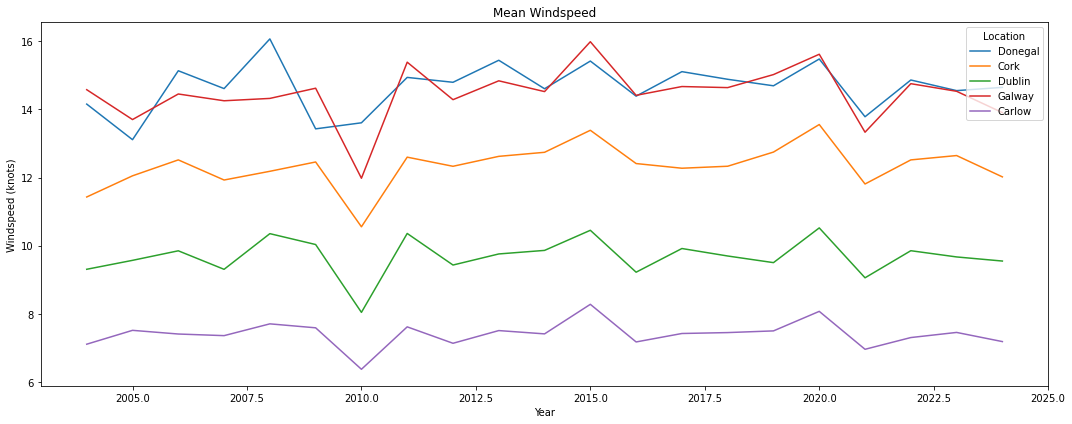

In [31]:
# plot line using seaborn
fig, ax = plt.subplots(figsize=(15, 6))

sns.lineplot(data=mean_yearly_df, x='year', y='wdsp_donegal', label='Donegal')
sns.lineplot(data=mean_yearly_df, x='year', y='wdsp_cork', label='Cork')
sns.lineplot(data=mean_yearly_df, x='year', y='wdsp_dublin', label='Dublin')
sns.lineplot(data=mean_yearly_df, x='year', y='wdsp_galway', label='Galway')
sns.lineplot(data=mean_yearly_df, x='year', y='wdsp_carlow', label='Carlow')

# decorate the plot
plt.xlabel("Year")
plt.ylabel("Windspeed (knots)")
plt.title(f"Mean Windspeed")
plt.legend(title='Location', loc='upper right')

plt.tight_layout()

Now to have a look at temperatures.

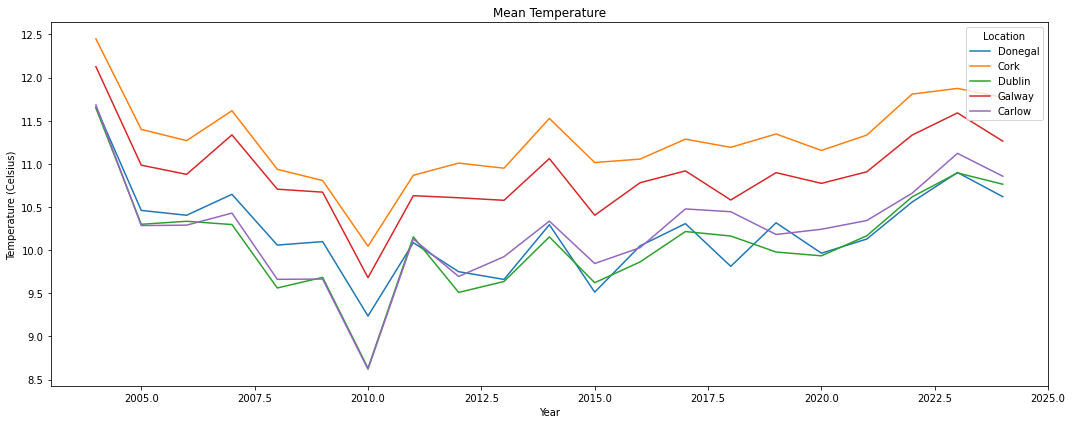

In [32]:
# Define the locations and corresponding column names
locations = {
    "Donegal": "temp_donegal",
    "Cork": "temp_cork",
    "Dublin": "temp_dublin",
    "Galway": "temp_galway",
    "Carlow": "temp_carlow",
}

# Set up canvas for plotting
fig, ax = plt.subplots(figsize=(15, 6))

# Plot each location in a loop
for location, column in locations.items():
    ax.plot(mean_yearly_df['year'], mean_yearly_df[column], label=location)

# Decorate the plot
ax.set_xlabel("Year")
ax.set_ylabel("Temperature (Celsius)")
ax.set_title("Mean Temperature")
ax.legend(title="Location", loc='upper right')
plt.tight_layout()


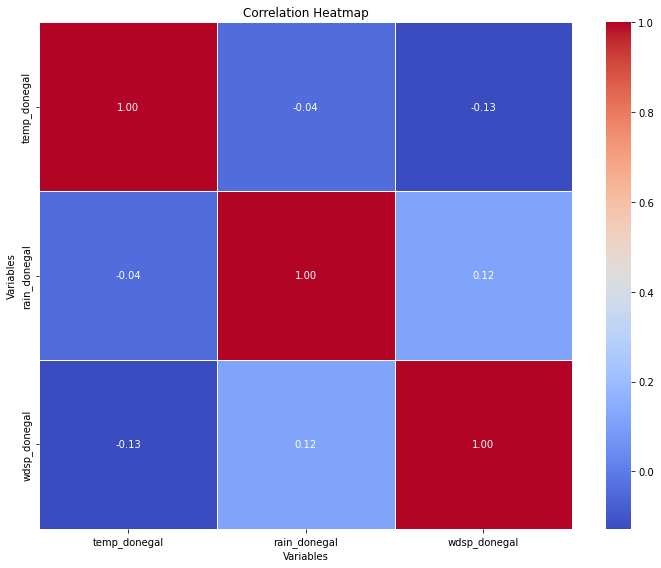

In [33]:
# Drop the 'date' column
df = donegal_df.drop(columns=['date'])

# Create the heatmap for the correlation matrix
plt.figure(figsize=(10, 8))  # Set the figure size
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Add labels and title
plt.title("Correlation Heatmap")
plt.xlabel("Variables")
plt.ylabel("Variables")

# Show the plot
plt.tight_layout()

KeyError: 'temp'

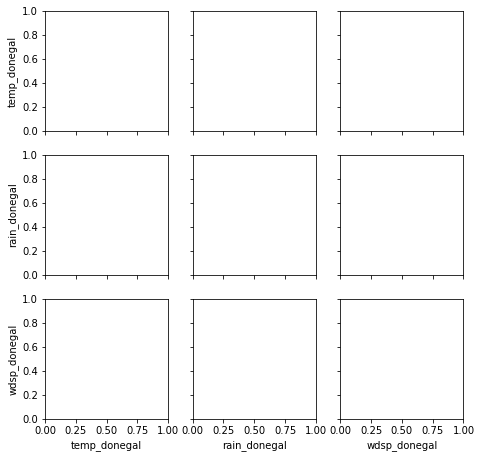

In [34]:
# plot pairplot using seaborn 
sns.pairplot(df, hue="temp")

### Linear Regression

scikit learn needs numeric columns, convert datetime to fractional years first.

In [ ]:
# Extract year and day of year from datetime
combined_df['year'] = df['date'].dt.year
combined_df['day_of_year'] = df['date'].dt.dayofyear

combined_df

,date,temp_donegal,rain_donegal,wdsp_donegal,temp_cork,rain_cork,wdsp_cork,temp_dublin,rain_dublin,wdsp_dublin,temp_galway,rain_galway,wdsp_galway,temp_carlow,rain_carlow,wdsp_carlow,year,day_of_year
24,2004-05-01 01:00:00,8.9,0.0,8.0,10.8,0.0,14.0,9.0,0.0,7.0,9.1,0.0,8.0,8.2,0.0,10.0,2003,214
25,2004-05-01 02:00:00,8.8,0.0,7.0,11.1,0.0,12.0,8.9,0.0,6.0,8.9,0.0,9.0,9.0,0.0,11.0,2003,214
26,2004-05-01 03:00:00,7.2,0.0,4.0,10.6,0.0,12.0,8.3,0.0,6.0,8.6,0.0,10.0,7.8,0.0,10.0,2003,214
27,2004-05-01 04:00:00,8.1,0.0,2.0,10.3,0.0,8.0,8.0,0.0,8.0,8.5,0.0,8.0,7.2,0.0,7.0,2003,214
28,2004-05-01 05:00:00,7.0,0.0,2.0,10.3,0.0,14.0,7.8,0.0,6.0,8.4,0.0,12.0,6.5,0.0,9.0,2003,214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180475,2024-11-30 20:00:00,14.6,0.0,23.0,12.8,0.0,17.0,14.0,0.1,19.0,12.5,0.0,24.0,13.4,0.5,16.0,2024,62
180476,2024-11-30 21:00:00,13.8,0.1,23.0,12.6,0.0,11.0,13.4,0.6,16.0,12.6,0.0,19.0,13.3,1.5,16.0,2024,62
180477,2024-11-30 22:00:00,13.4,0.0,20.0,12.7,0.0,12.0,13.6,0.2,15.0,11.5,1.3,21.0,13.4,0.2,13.0,2024,62
180478,2024-11-30 23:00:00,12.6,0.0,20.0,12.7,0.0,14.0,13.4,0.0,15.0,12.2,0.2,18.0,13.1,0.3,14.0,2024,62


In [ ]:
# Calculate fractional year
combined_df['fractional_year'] = combined_df['year'] + (combined_df['day_of_year'] - 1) / 365

combined_df

,date,temp_donegal,rain_donegal,wdsp_donegal,temp_cork,rain_cork,wdsp_cork,temp_dublin,rain_dublin,wdsp_dublin,temp_galway,rain_galway,wdsp_galway,temp_carlow,rain_carlow,wdsp_carlow,year,day_of_year,fractional_year
24,2004-05-01 01:00:00,8.9,0.0,8.0,10.8,0.0,14.0,9.0,0.0,7.0,9.1,0.0,8.0,8.2,0.0,10.0,2003,214,2003.583562
25,2004-05-01 02:00:00,8.8,0.0,7.0,11.1,0.0,12.0,8.9,0.0,6.0,8.9,0.0,9.0,9.0,0.0,11.0,2003,214,2003.583562
26,2004-05-01 03:00:00,7.2,0.0,4.0,10.6,0.0,12.0,8.3,0.0,6.0,8.6,0.0,10.0,7.8,0.0,10.0,2003,214,2003.583562
27,2004-05-01 04:00:00,8.1,0.0,2.0,10.3,0.0,8.0,8.0,0.0,8.0,8.5,0.0,8.0,7.2,0.0,7.0,2003,214,2003.583562
28,2004-05-01 05:00:00,7.0,0.0,2.0,10.3,0.0,14.0,7.8,0.0,6.0,8.4,0.0,12.0,6.5,0.0,9.0,2003,214,2003.583562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180475,2024-11-30 20:00:00,14.6,0.0,23.0,12.8,0.0,17.0,14.0,0.1,19.0,12.5,0.0,24.0,13.4,0.5,16.0,2024,62,2024.167123
180476,2024-11-30 21:00:00,13.8,0.1,23.0,12.6,0.0,11.0,13.4,0.6,16.0,12.6,0.0,19.0,13.3,1.5,16.0,2024,62,2024.167123
180477,2024-11-30 22:00:00,13.4,0.0,20.0,12.7,0.0,12.0,13.6,0.2,15.0,11.5,1.3,21.0,13.4,0.2,13.0,2024,62,2024.167123
180478,2024-11-30 23:00:00,12.6,0.0,20.0,12.7,0.0,14.0,13.4,0.0,15.0,12.2,0.2,18.0,13.1,0.3,14.0,2024,62,2024.167123


In [ ]:
# check for empties
combined_df.isna().sum()

date               0
temp_donegal       0
rain_donegal       0
wdsp_donegal       0
temp_cork          0
rain_cork          0
wdsp_cork          0
temp_dublin        0
rain_dublin        0
wdsp_dublin        0
temp_galway        0
rain_galway        0
wdsp_galway        0
temp_carlow        0
rain_carlow        0
wdsp_carlow        0
year               0
day_of_year        0
fractional_year    0
dtype: int64

In [ ]:
# remove empties
combined_df.dropna(inplace=True)

In [ ]:
# check empties again
combined_df.isna().sum()

date               0
temp_donegal       0
rain_donegal       0
wdsp_donegal       0
temp_cork          0
rain_cork          0
wdsp_cork          0
temp_dublin        0
rain_dublin        0
wdsp_dublin        0
temp_galway        0
rain_galway        0
wdsp_galway        0
temp_carlow        0
rain_carlow        0
wdsp_carlow        0
year               0
day_of_year        0
fractional_year    0
dtype: int64

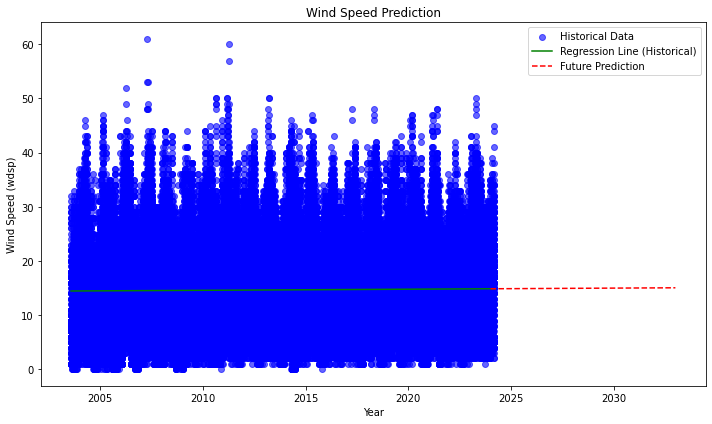

In [ ]:
# select variables to plot
X = combined_df[['fractional_year']]
y = combined_df['wdsp_donegal']

# train the linear regression model
model = LinearRegression()
model.fit(X, y)

# predict wind speeds for historical data
historical_predictions = model.predict(X)

# predict future wind speeds 10 years ahead
future_years = pd.DataFrame({'fractional_year': np.arange(2024, 2034)})  # adds future years into fractional_year column
future_predictions = model.predict(future_years)

# plot the results
plt.figure(figsize=(10, 6))

# plot historical data
plt.scatter(X, y, label='Historical Data', color='blue', alpha=0.6)

# plot regression line
plt.plot(X, historical_predictions, color='green', label='Regression Line (Historical)')

# plot future predictions

plt.plot(future_years, future_predictions, color='red', linestyle='--', label='Future Prediction')

# Decorate the plot
plt.xlabel('Year')
plt.ylabel('Wind Speed (wdsp)')
plt.title('Wind Speed Prediction')
plt.legend()
plt.tight_layout()

### Clustering

In [ ]:
# create a months column
combined_df['month'] = combined_df['date'].dt.month

In [ ]:
# view dataframe
combined_df

,date,temp_donegal,rain_donegal,wdsp_donegal,temp_cork,rain_cork,wdsp_cork,temp_dublin,rain_dublin,wdsp_dublin,...,wdsp_galway,temp_carlow,rain_carlow,wdsp_carlow,year,day_of_year,fractional_year,month,cluster,season
24,2004-05-01 01:00:00,8.9,0.0,8.0,10.8,0.0,14.0,9.0,0.0,7.0,...,8.0,8.2,0.0,10.0,2003,214,2003.583562,5,0,Spring
25,2004-05-01 02:00:00,8.8,0.0,7.0,11.1,0.0,12.0,8.9,0.0,6.0,...,9.0,9.0,0.0,11.0,2003,214,2003.583562,5,0,Spring
26,2004-05-01 03:00:00,7.2,0.0,4.0,10.6,0.0,12.0,8.3,0.0,6.0,...,10.0,7.8,0.0,10.0,2003,214,2003.583562,5,0,Spring
27,2004-05-01 04:00:00,8.1,0.0,2.0,10.3,0.0,8.0,8.0,0.0,8.0,...,8.0,7.2,0.0,7.0,2003,214,2003.583562,5,0,Spring
28,2004-05-01 05:00:00,7.0,0.0,2.0,10.3,0.0,14.0,7.8,0.0,6.0,...,12.0,6.5,0.0,9.0,2003,214,2003.583562,5,0,Spring
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180475,2024-11-30 20:00:00,14.6,0.0,23.0,12.8,0.0,17.0,14.0,0.1,19.0,...,24.0,13.4,0.5,16.0,2024,62,2024.167123,11,1,Autumn
180476,2024-11-30 21:00:00,13.8,0.1,23.0,12.6,0.0,11.0,13.4,0.6,16.0,...,19.0,13.3,1.5,16.0,2024,62,2024.167123,11,1,Autumn
180477,2024-11-30 22:00:00,13.4,0.0,20.0,12.7,0.0,12.0,13.6,0.2,15.0,...,21.0,13.4,0.2,13.0,2024,62,2024.167123,11,1,Autumn
180478,2024-11-30 23:00:00,12.6,0.0,20.0,12.7,0.0,14.0,13.4,0.0,15.0,...,18.0,13.1,0.3,14.0,2024,62,2024.167123,11,1,Autumn


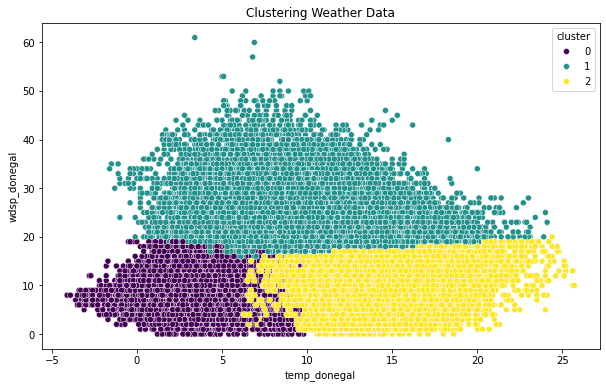

In [ ]:
from sklearn.cluster import KMeans

# Assuming you have added year, month, weekday features from the previous steps
X = combined_df[['wdsp_donegal', 'temp_donegal', 'rain_donegal', 'month']]

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Specify the number of clusters
combined_df['cluster'] = kmeans.fit_predict(X)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='temp_donegal', y='wdsp_donegal', hue='cluster', data=combined_df, palette='viridis')
plt.title("Clustering Weather Data")
plt.show()


Migth be mor useful to colr by season.

In [ ]:
# add a season column
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'

# apply the function to create the season column
combined_df['season'] = combined_df['month'].apply(get_season)


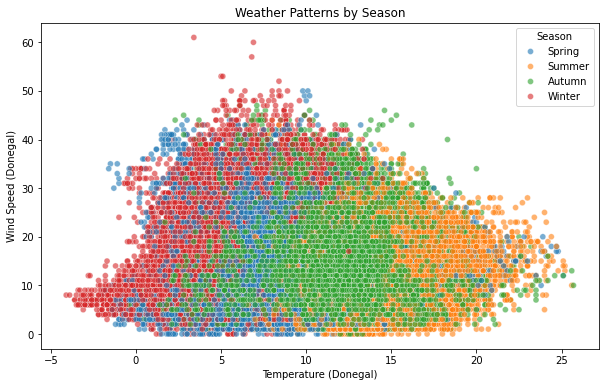

In [ ]:
# plot the season 
plt.figure(figsize=(10, 6))

sns.scatterplot(
    x='temp_donegal', 
    y='wdsp_donegal', 
    hue='season', 
    data=combined_df, 
    alpha=0.6
)

plt.title("Weather Patterns by Season")
plt.xlabel("Temperature (Donegal)")
plt.ylabel("Wind Speed (Donegal)")
plt.legend(title="Season")


### Windfarm Locations

Data from https://data.gov.ie/dataset/wind-farms-in-ireland

Plot map of Ireland first then plot windfarm location data on top.

In [ ]:
# define the url to windfarm location data
#windfarm_url = "https://seaiopendata.blob.core.windows.net/wind/WindFarmsJune2022_ESPG3857.zip"

# define the path to the downloaded shapefile
#windfarm_shp_path = "./data/WindFarmsJune2022_ESPG3857/Wind Farms June 2022_ESPG3857.shp"

Plot the map. Geopandas is an open-source library for plotting geospatial data.

- https://geopandas.org/en/stable/about.html

A compass on the map would look nice. Needs to be svg (vector). Found a library called skunk. 

- https://github.com/whitead/skunk

It allows use of svg with matplotlib.

Ciaro is a command-line tool that can also be used in python, allowing for conversion between svg, png, pdf etc.

- https://cairosvg.org/documentation/

Before plotting the shapefiles, we have to convert them all to the same coordinate reference system (crs) - ESPG4326. 

In [ ]:
# Load the Ireland shapefile
main_map_path = "./data/Ireland_Shapefiles_ITM/Ireland_CountyBoundaries_ITM.shp"
main_map = gpd.read_file(main_map_path)
print(f"Ireland shapefile CRS: {main_map.crs}")

# Load the windfarm locations shapefile
windfarm_locations_path = "./data/WindFarmsJune2022_ESPG3857/Wind Farms June 2022_ESPG3857.shp"
windfarm_locations = gpd.read_file(windfarm_locations_path)
print(f"Windfarm locations CRS: {windfarm_locations.crs}")

# Convert both shapefiles to EPSG:4326
main_map = main_map.to_crs("EPSG:4326")
windfarm_locations = windfarm_locations.to_crs("EPSG:4326")
print(f"Ireland shapefile CRS after conversion: {main_map.crs}")
print(f"Windfarm locations CRS after conversion: {windfarm_locations.crs}")

Ireland shapefile CRS: EPSG:2157
Windfarm locations CRS: EPSG:3857
Ireland shapefile CRS after conversion: EPSG:4326
Windfarm locations CRS after conversion: EPSG:4326


Now try to plot the station locations as well as existing windfarm locations. The csv files have this data in the headers, as well as the station name.

** try to parse automatically later

Given positional coordinates, a point can be drawn on the map using the [Point class](https://shapely.readthedocs.io/en/stable/manual.html#points) from the [Shapely](https://shapely.readthedocs.io/en/stable/manual.html) library. A GeoDataFrame is created from the shapely object, which can then be plotted:

- https://geopandas.org/en/stable/gallery/create_geopandas_from_pandas.html


In [ ]:
# Define weather station locations
weather_stations = [
    {'name': 'Malin Head', 'Latitude': 55.372, 'Longitude': -7.339},        # donegal
    {'name': 'Sherkin Island', 'Latitude': 51.476, 'Longitude': -9.428},    # cork
    {'name': 'Casement', 'Latitude': 53.306, 'Longitude': -6.439},          # dublin
    {'name': 'Mace Head', 'Latitude': 53.362, 'Longitude': -9.901},         # galway
    {'name': 'Oak Park', 'Latitude': 52.861, 'Longitude': -6.915},          # carlow
]

# Create a GeoDataFrame for the weather stations
geometry = [Point(item['Longitude'], item['Latitude']) for item in weather_stations]
station_gdf = gpd.GeoDataFrame(weather_stations, geometry=geometry, crs="EPSG:4326")


In [ ]:
# Set up figure, axis
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_facecolor('lightblue')  # Set background color (water)

# Plot the Ireland shapefile
main_map.plot(ax=ax, color='#083527', edgecolor='black')

# Plot windfarm locations
windfarm_locations.plot(ax=ax, color='orange', marker='o', label='Wind Farm')

# Plot weather station locations
station_gdf.plot(ax=ax, color='red', marker='^', markersize=100, label='Weather Station')

# Add labels for weather stations
for x, y, label in zip(station_gdf.geometry.x, station_gdf.geometry.y, station_gdf['name']):
    ax.text(x, y, label, fontsize=8, ha='right', color='white', bbox=dict(facecolor='black', alpha=0.4))

# Add title, legend, labels
plt.legend(loc='lower right', bbox_to_anchor=(0.96, 0.06))
plt.title("Wind Farm Locations, Ireland")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Insert compass SVG in the top-left using skunk
box_compass = skunk.Box(125, 125, 'sk1')  # Create a skunk box for the compass
ab_compass = AnnotationBbox(box_compass, (0.18, 0.86),  # Position in top-left
                             xycoords='axes fraction',
                             boxcoords='offset points',
                             frameon=False)
ax.add_artist(ab_compass)

# Insert the SVGs into skunk
svg = skunk.insert(
    {
        'sk1': './data/compass.svg'  # Path to the compass.svg
    })

# Display the SVG in Jupyter Notebook
skunk.display(svg)

# Do not display the plot
plt.close(fig)  # This will prevent the plot from displaying in Jupyter Notebook

# Save the figure if needed
#fig.savefig("test.png")

# save map to pdf and png
cairosvg.svg2pdf(bytestring=svg, write_to='./data/map.pdf')
cairosvg.svg2png(bytestring=svg, write_to='./data/map.png')

# Convert SVG to PNG
cairosvg.svg2png(svg, write_to='./data/map.png')
print("Saved as map.png in data folder")

Saved as map.png in data folder


The skunk svg doesn't render correctly in Jupyter, so it was saved as png and displayed below.

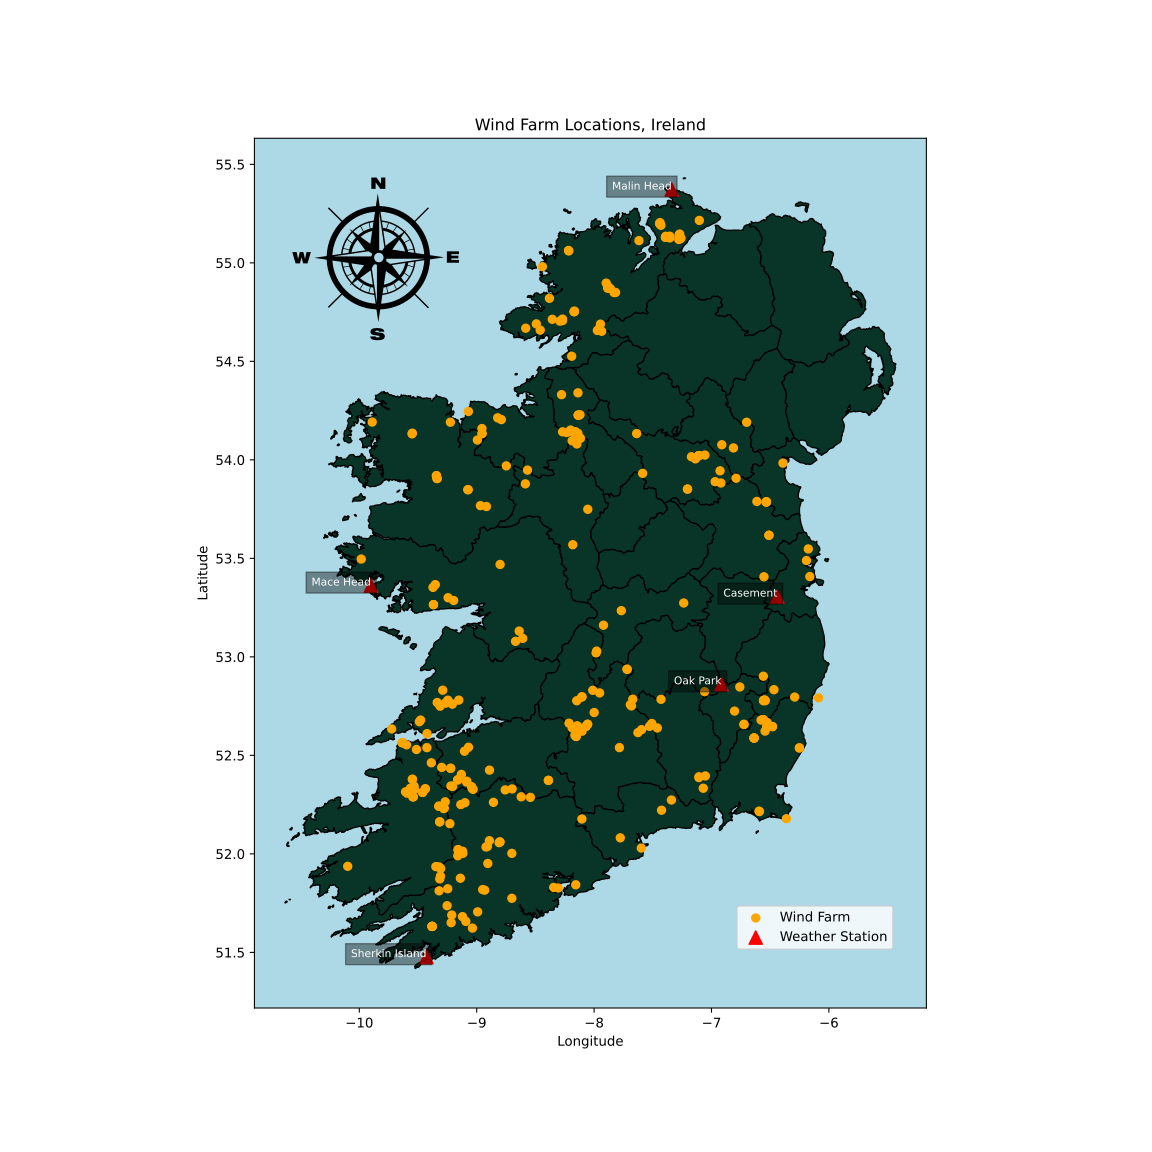

In [ ]:
# Display the PNG file
Image(filename='./data/map.png')

***

### END